In [1]:
import numpy as np

def Tree_Hamiltonian(order: int=4, gamma: float=1.) -> np.ndarray:
    
    if order==1:
        A = np.array([[2, -1, -1, 0],
                      [-1, 2, 0, -1],
                      [-1, 0, 2, -1],
                      [0, -1, -1, 2]])
        return gamma*A
    
    else:
        B = Tree_Hamiltonian(order-1, 1)
        sizeb = len(B)
        size = int(2*sizeb+2)
        A = np.zeros((size, size))
        
        A[0,0], A[-1,-1] = 2, 2
        A[1,1], A[sizeb+1,sizeb+1], A[sizeb,sizeb], A[-2,-2] = 1, 1, 1, 1
        A[0,1], A[1,0], A[0,sizeb+1], A[sizeb+1,0] = -1, -1, -1, -1
        A[-1,sizeb], A[sizeb,-1], A[-1,-2], A[-2,-1] = -1, -1, -1, -1
        
        B1 = np.pad(B, [(1, size-sizeb-1), (1, size-sizeb-1)], mode='constant')
        B2 = np.pad(B, [(sizeb+1, 1), (sizeb+1, 1)], mode='constant')
        A += B1
        A += B2
        
        return gamma*A

In [2]:
import numpy as np

def Tree_MSD_weight(order: int=4) -> np.ndarray:
    
    if order==1:
        A = np.array([0,1,1,2])
        return A**2
    
    else:
        B = np.sqrt(Tree_MSD_weight(order-1))
        sizeb = len(B)
        size = int(2*sizeb+2)
        A = np.zeros(size)
        
        A[0], A[-1] = 0, 2*order
        B1 = np.pad(B + 1, [(1, size-sizeb-1)], mode='constant')
        B2 = np.pad(B + 1, [(sizeb+1, 1)], mode='constant')
        A += B1
        A += B2
        
        return A**2

In [3]:
import numpy as np

def Tree_Pos(order: int=4) -> np.ndarray:
    
    if order==1:
        A = np.array([[-1, 0],
                      [0, .5], [0, -.5],
                      [1, 0]])
        return A
    
    else:
        B = Tree_Pos(order-1)
        sizeb = len(B)
        size = int(2*sizeb+2)
        A = np.zeros((size, 2))
        
        A[0], A[-1] = [-1,0], [1,0]
        B1 = np.pad(B * [(order-1)/order, .5] + [0, .5], [(1, size-sizeb-1), (0, 0)], mode='constant')
        B2 = np.pad(B * [(order-1)/order, .5] - [0, .5], [(sizeb+1, 1), (0, 0)], mode='constant')
        A += B1
        A += B2
        
        return A

In [4]:
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   ((0.00, 0.00, 0.00), 
                   (0.20, 0.95, 0.95),
                   (0.40, 0.95, 0.95),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'green': ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.50, 0.50),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'blue':  ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.30, 0.30),
                   (0.60, 0.50, 0.50),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.95, 0.95))
          }

cmap = LinearSegmentedColormap('star', cdict)

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_distribution(G, pos, node_size=100, node_color="#1f78b4", mapper=None, cmap=None, vmin=None, vmax=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    cb = plt.colorbar(mapper, ax=ax, extend='min')
    cb.ax.tick_params(labelsize=12)
    ax.axis('off')
    
    return nodes

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [7]:
def qw(Hamiltonian: np.ndarray, t: float=1.) -> np.ndarray:
    
    H = Hamiltonian
    size = len(H)
    psi0 = np.zeros(size)
    psi0[0] = 1

    return abs(np.matmul(expm(-1j*np.pi*H*t), psi0))**2

In [8]:
order = 4
steps = 1500
dt = .01
t = np.linspace(dt, steps*dt, steps)
gamma = 1.

folder = 'data/exact/'
video_folder = 'videos/'
name = f'exact_tree_qw_ex_o{order}_{steps*dt:.1f}s_{steps:d}vly'

In [9]:
counts_list = np.zeros_like(t, dtype=object)
per10 = steps/10

for i in range(steps):
    counts_list[i] = qw(Tree_Hamiltonian(order, gamma), t[i])
    if i%per10==0:
        print(f'{int(i/per10)*10}%', end='\r')
print(f'{100}% complete!')

100% complete!


In [10]:
msd_list = np.zeros_like(t, dtype=object)
msd_weight = Tree_MSD_weight(order)

for i in range(steps):
    msd_list[i] = (counts_list[i]*msd_weight).sum()

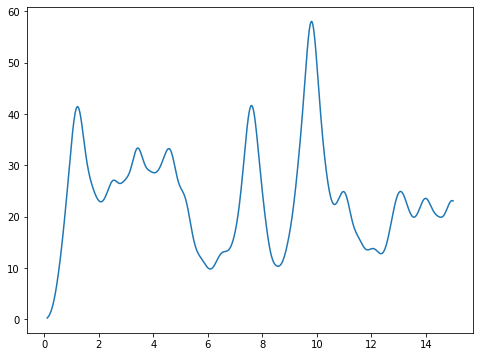

In [11]:
fig = plt.figure(figsize=(8, 6))
plt.plot(t[10:], msd_list[10:])
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [12]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

G = nx.from_numpy_array(abs(Tree_Hamiltonian(order, gamma)))
G.remove_edges_from(nx.selfloop_edges(G))
pos = Tree_Pos(order)

vmin = 10**(1-order)
vmax = 1.
mapper = ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

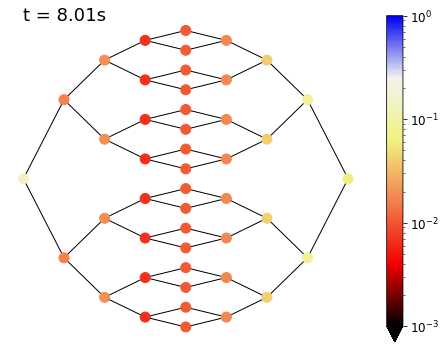

In [13]:
choose = 800

dpi = 72
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[choose]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % ((choose+1)*dt), fontsize=18)

plt.show()

In [14]:
import csv

with open(f'{folder}{name}_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [15]:
import pickle

with open(f'{folder}{name}_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [16]:
from matplotlib import animation

dpi = 300
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[0]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % 0., fontsize=18)

def animate(i):
    global nodes, time_text
    nodes.remove()
    time_text.remove()
    node_color = counts_list[i]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=mapper.to_rgba(node_color))
    time_text = ax.text(-1, 1, time_template % ((i+1)*dt), fontsize=18)
    return 0

ani = animation.FuncAnimation(fig, animate, frames=steps, interval=10)

def progress_callback(i, n):
    print(f'Saving frame {i} of {n}', end='\r')
    return 0

writer = animation.writers['ffmpeg'](fps=100)
ani.save(f'{video_folder}{name}_animation.mp4', writer=writer, dpi=dpi, progress_callback=progress_callback)
del ani
plt.close(fig)
print(f'Saving frame {steps} of {steps} complete!')

Saving frame 1500 of 1500 complete!


In [7]:
def rw(Hamiltonian: np.ndarray, t: float=1.) -> np.ndarray:
    
    H = Hamiltonian
    size = len(H)
    psi0 = np.zeros(size)
    psi0[0] = 1

    return np.matmul(expm(-np.pi*H*t), psi0)

In [8]:
order = 4
steps = 1500
dt = .01
t = np.linspace(dt, steps*dt, steps)
gamma = 1.

folder = 'data/exact/'
video_folder = 'videos/'
name = f'exact_tree_rw_ex_o{order}_{steps*dt:.1f}s_{steps:d}vly'

In [9]:
counts_list = np.zeros_like(t, dtype=object)
per10 = steps/10

for i in range(steps):
    counts_list[i] = rw(Tree_Hamiltonian(order, gamma), t[i])
    if i%per10==0:
        print(f'{int(i/per10)*10}%', end='\r')
print(f'{100}% complete!')

100% complete!


In [10]:
msd_list = np.zeros_like(t, dtype=object)
msd_weight = Tree_MSD_weight(order)

for i in range(steps):
    msd_list[i] = (counts_list[i]*msd_weight).sum()

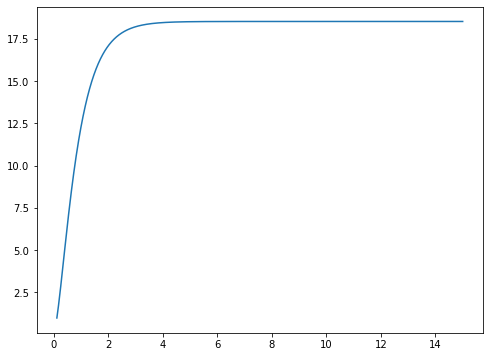

In [11]:
fig = plt.figure(figsize=(8, 6))
plt.plot(t[10:], msd_list[10:])
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [12]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

G = nx.from_numpy_array(abs(Tree_Hamiltonian(order, gamma)))
G.remove_edges_from(nx.selfloop_edges(G))
pos = Tree_Pos(order)

vmin = 10**(1-order)
vmax = 1.
mapper = ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

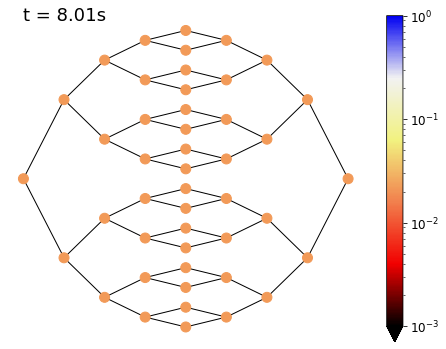

In [13]:
choose = 800

dpi = 72
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[choose]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % ((choose+1)*dt), fontsize=18)

plt.show()

In [24]:
import csv

with open(f'{folder}{name}_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [25]:
import pickle

with open(f'{folder}{name}_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [26]:
from matplotlib import animation

dpi = 300
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[0]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % 0., fontsize=18)

def animate(i):
    global nodes, time_text
    nodes.remove()
    time_text.remove()
    node_color = counts_list[i]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=mapper.to_rgba(node_color))
    time_text = ax.text(-1, 1, time_template % ((i+1)*dt), fontsize=18)
    return 0

ani = animation.FuncAnimation(fig, animate, frames=steps, interval=10)

def progress_callback(i, n):
    print(f'Saving frame {i} of {n}', end='\r')
    return 0

writer = animation.writers['ffmpeg'](fps=100)
ani.save(f'{video_folder}{name}_animation.mp4', writer=writer, dpi=dpi, progress_callback=progress_callback)
del ani
plt.close(fig)
print(f'Saving frame {steps} of {steps} complete!')

Saving frame 1500 of 1500 complete!
